# Studio della variazione di K0 durante un forbush

Lo studio mira a stimare quale è la variazione del fattore di K0 durante il passaggio di un forbush
|FD   |Type | Time | MAR  | Ampl |  
|:---:|:---:|:---:|:---:|:---:| 
| 006 |ICME | 2011/08     | 16.6 | 13.6 |
| 010 |ICME | 2011/10     | 48.5 | 10.3 |
| 017 |ICME | 2012/03     | 33.5 | 35.1 |
| 058 |ICME | 2014/02     | 33.5 | 10.0 |
| 121 |ICME | 2017/09     | 22.8 | 17.7 |

In [1]:
# Lista FD da analizzare
FDList = ["006","010","017","058","121"]
#FDList = ["006","010","058"]

In [2]:
# import librerie
import pickle
import matplotlib.pyplot as plt
import json
import numpy as np
from scipy.optimize import curve_fit
import glob


import matplotlib as mpl
import matplotlib.ticker as tck
import matplotlib.colors as mcolors
axis_font = {'fontname':'DejaVu Sans', 'size':'12'}
yaxis_font = {'fontname':'DejaVu Sans', 'size':'12'}
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
mpl.rcParams['xtick.major.size']=8
mpl.rcParams['xtick.minor.size']=4
mpl.rcParams['ytick.major.size']=8
mpl.rcParams['ytick.minor.size']=4
mpl.rcParams['axes.linewidth']=1.5
mpl.rcParams['xtick.major.width']=1.5
mpl.rcParams['xtick.minor.width']=1.5
mpl.rcParams['ytick.major.width']=1.5
mpl.rcParams['ytick.minor.width']=1.5  
mpl.rcParams['xtick.top']=True
mpl.rcParams['ytick.right']=True
mpl.rcParams['xtick.direction']="in"
mpl.rcParams['ytick.direction']="in"
mpl.rcParams['figure.dpi']=150
mpl.rcParams['figure.figsize']=[6,5]

In [3]:
# funzioni leggi_files_pkl_from_FDid

def leggi_files_pkl_from_FDid(FDid):
    file_paths = glob.glob(f'Result_FD{FDid}*.pkl')    
    # apri il primo file e estrai le variabili fisse
    joinData = {}
    with open(file_paths[0], 'rb') as f:
        joinData = pickle.load(f)


    # Legge i file e unisce gli array AllFlux e AllK0
    for file_path in file_paths[1:]:
        with open(file_path, 'rb') as f:
            data = pickle.load(f)
            for ion in list(data):
                print(f"---{ion}---")
                for T in list(data[ion])[:1]:
                    for time in data[ion][T]:
                        if "AllFlux" in data:
                            joinData[ion][T][time]["AllFlux"].extend(data[ion][T][time]["AllFlux"])
                        if "AllK0" in data:
                            joinData[ion][T][time]["AllK0"].extend(data[ion][T][time]["AllK0"])
    
    # for ion in list(joinData):
    #     print(f"---{ion}---")
    #     for T in list(joinData[ion])[:1]:
    #         for time in joinData[ion][T]:
    #             print(f"-- {T} GV {time}------------------")
    #             print(json.dumps(joinData[ion][T][time], indent=4))

    for ion in list(joinData):
        print(f"---{ion}---")
        for T in list(joinData[ion])[:1]:
            for time in joinData[ion][T]:
                #.. cicla sulle soluzioni alla ricerca del best value


                for K0,F in list(zip(joinData[ion][T][time]["AllK0"],joinData[ion][T][time]["AllFlux"])):
                    
                    RefEntry=joinData[ion][T][time]
                    DiffVal = F-RefEntry['fExp']
                    Tolerance= F*(1200)**(-1/2)
                    #print(Tolerance)
                    if -RefEntry['ErExp_inf']-Tolerance<=DiffVal<=+RefEntry['ErExp_sup']+Tolerance :
                        if np.fabs(DiffVal)<np.fabs(RefEntry['diffBest']):
                            joinData[ion][T][time]['diffBest']=DiffVal
                            joinData[ion][T][time]['K0best']  =K0
                            joinData[ion][T][time]['Fluxbest']=F
                        if RefEntry['K0Min']>K0 :
                            joinData[ion][T][time]['FluxMin']=F
                            joinData[ion][T][time]['K0Min']  =K0
                        if RefEntry['K0Max']<K0 :
                            joinData[ion][T][time]['FluxMax']=F
                            joinData[ion][T][time]['K0Max']  =K0
    return joinData
    


In [4]:
# Funzione per leggere il file Result.pkl
def leggi_file_pkl(file_path):
    with open(file_path, 'rb') as f:
        data = pickle.load(f)
    return data

# Funzione per creare grafici per ogni energia
def crea_grafici_singolo(data):
    for energia, tempo_k0 in data.items():
        tempi = list(tempo_k0.keys())
        output_k0 = list(tempo_k0.values())
        valori_k0 = [ f['K0best'] for f in output_k0]

        # Creazione del grafico
        plt.figure(figsize=(10, 6))
        plt.plot(tempi, valori_k0, marker='o', linestyle='-', label=f'Energia: {energia}')
        plt.title('Grafico di K0 nel tempo')
        plt.xlabel('Tempo')
        plt.ylabel('Valore di K0')
        plt.legend()
        plt.grid(True)
        plt.show()

# Funzione per creare grafici per ogni energia
def crea_grafici_K0Flusso_SingleEnergy(data):
    for energia, tempo_k0 in data.items():
        tempi = list(tempo_k0.keys())
        output_k0 = list(tempo_k0.values())
        valori_k0 = [ f['K0best'] for f in output_k0]
        print(valori_k0)
        valori_k0Ref    = np.array([ f['K0ref'] for f in output_k0])
        valori_k0errRef = np.array([ f['K0Err_ref'] for f in output_k0])
        
        
        valori_fluss = np.array([ f['Fluxbest'] for f in output_k0])
        valori_fExp      = np.array([ f['fExp'] for f in output_k0])
        valori_ErExp_inf = np.array([ f['ErExp_inf'] for f in output_k0])
        valori_ErExp_sup = np.array([ f['ErExp_sup'] for f in output_k0])
        

        # Creazione del grafico
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 4), sharex=True)
        ax1.plot(tempi, valori_k0, marker='o', linestyle='-', label=f'Energia: {energia}')
        # riferimento
        ax1.plot(tempi, valori_k0Ref,'--k')
        ax1.fill_between(tempi, valori_k0Ref-valori_k0errRef,valori_k0Ref+valori_k0errRef, alpha=0.5)
        ax1.set_title(f'K0 nel tempo: {energia} GV')
        #ax1.xlabel('Tempo')
        ax1.set_ylabel('K0')
        ax1.set_ylim([0.5e-6,3.5e-4])
        #plt.legend()
        ax1.grid(True)

        ax2.plot(tempi, valori_fluss, marker='o', linestyle='-', label=f'Energia: {energia}')
        ax2.errorbar(tempi,valori_fExp,yerr=[valori_ErExp_inf,valori_ErExp_sup],fmt=".k")
        ax2.set_xlabel('Tempo')
        ax2.set_ylabel('Flusso')
        #plt.legend()
        ax2.set_ylim([np.min(valori_fExp-6*valori_ErExp_inf),np.max(valori_fExp+6*valori_ErExp_sup)])
        ax2.grid(True)
        plt.tight_layout()
        plt.show()


# Funzione per creare grafici per tutte le energia
def crea_grafici_K0Flusso_AllEnergies(data,Emin=-1,Emax=-1,FDid='000'):
    # ottieni lista energia
    Elist=data.keys()
    if Emin==-1: Emin=min(Elist)
    else: Emin = min(Elist, key=lambda x: abs(x - Emin))
    if Emax==-1: Emax=max(Elist)
    else: Emax = min(Elist, key=lambda x: abs(x - Emax))

    # Creazione del grafico
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 4), sharex=True)
    ax1.set_title(f'FD{FDid}')
    #ax1.xlabel('Tempo')
    ax1.set_ylabel('Diffusion Parameter')
    K0lim=[0.5e-6,5.5e-4]
    
    #plt.legend()
    ax1.grid(True)
    #ax2.set_xlabel('Tempo')
    ax2.set_ylabel('Normalized flux')
    #plt.legend()
    ax2MinVal=0.7
    ax2.grid(True)
    
    fig.align_ylabels((ax1, ax2))
    # per ogni bin di energia plotta i valori di K0 e flusso

    for energia, tempo_k0 in data.items():
        tempi = list(tempo_k0.keys())
        output_k0 = list(tempo_k0.values())
        valori_k0 = [ f['K0best'] for f in output_k0]
        valori_k0min = [ f['K0Min'] for f in output_k0]
        valori_k0max = [ f['K0Max'] for f in output_k0]
        #print(valori_k0)
        #estrai valor K0 di riferimento
        if energia==Emin:
            valori_k0Ref    = np.array([ f['K0ref'] for f in output_k0])
            valori_k0errRef = np.array([ f['K0Err_ref'] for f in output_k0])

        # estrai valori di flusso
        valori_fluss    = np.array([ f['Fluxbest'] for f in output_k0])
        valori_min      = np.array([ f['FluxMin'] for f in output_k0])
        valori_max      = np.array([ f['FluxMax'] for f in output_k0])
        valori_fExp      = np.array([ f['fExp'] for f in output_k0])
        valori_ErExp_inf = np.array([ f['ErExp_inf'] for f in output_k0])
        valori_ErExp_sup = np.array([ f['ErExp_sup'] for f in output_k0])
        #normalizza alla media dei primi 4 giorni
        AverFluxQuite = np.mean(valori_fExp[:4])
        valori_fluss     = valori_fluss/AverFluxQuite
        valori_min       = valori_min/AverFluxQuite
        valori_max       = valori_max/AverFluxQuite
        valori_fExp      = valori_fExp/AverFluxQuite
        valori_ErExp_inf = valori_ErExp_inf/AverFluxQuite
        valori_ErExp_sup = valori_ErExp_sup/AverFluxQuite

        # stampa valori flusso
        ax2.plot(tempi, valori_fluss, marker='o', linestyle='-', label=f'{energia} GV')
        ax2.fill_between(tempi,valori_min,valori_max,alpha=0.5)
        ax2.errorbar(tempi,valori_fExp,yerr=[valori_ErExp_inf,valori_ErExp_sup],fmt=".k")
        if np.min(valori_fluss[valori_fluss != 0])<ax2MinVal : 
            ax2MinVal=np.min(valori_fluss[valori_fluss != 0])-0.3
        
        #stampa valori K0
        ax1.plot(tempi, valori_k0, marker='o', linestyle='-', label=f'{energia} GV')
        ax1.fill_between(tempi,valori_k0min,valori_k0max,alpha=0.5)
    
    ax2.set_ylim([ax2MinVal,1.05])
    ax1.plot(tempi, valori_k0Ref,'--k')
    ax1.fill_between(tempi, valori_k0Ref-valori_k0errRef,valori_k0Ref+valori_k0errRef, alpha=0.5)
    K0lim[1]=np.max(valori_k0Ref+valori_k0errRef)+0.0003
    ax1.set_ylim(K0lim)
    
    #ax1.legend(ncols=7)
    ax2.legend(ncols=7)
    plt.tight_layout()
    #plt.show()
    plt.savefig(f"TimeVar_FD{FDid}.png",dpi=300)




==================== 006 ==================== 
---Proton---
==================== 010 ==================== 
---Proton---
==================== 017 ==================== 
---Proton---
==================== 058 ==================== 
---Proton---
==================== 121 ==================== 
---Proton---


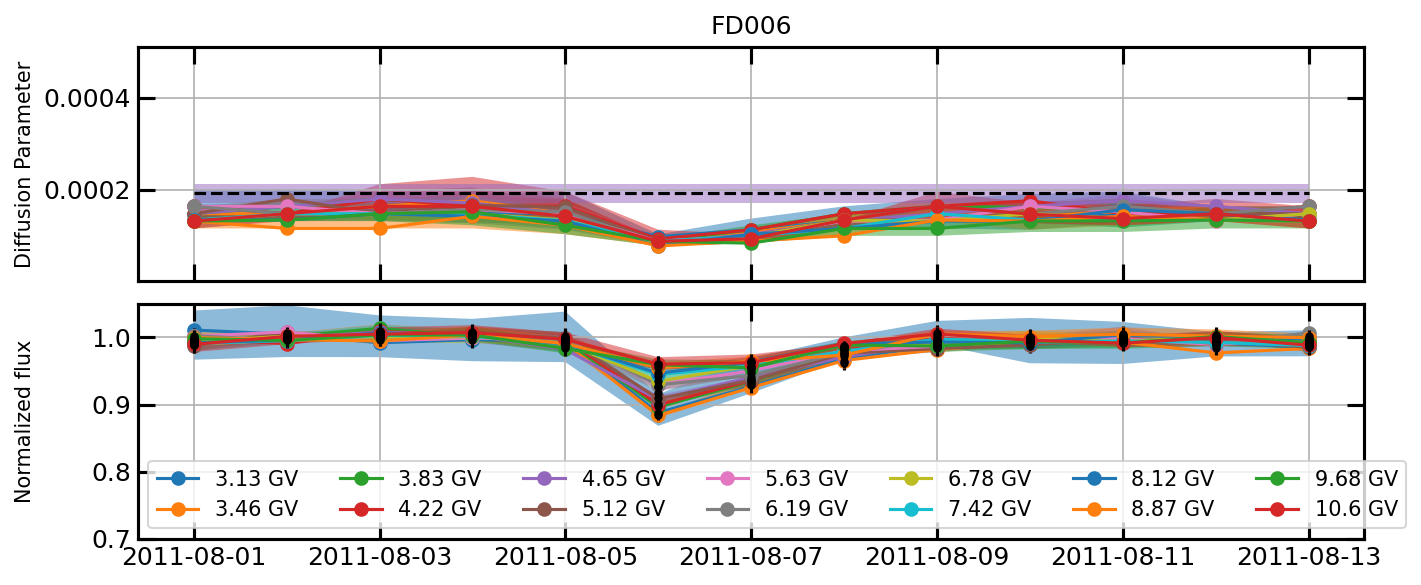

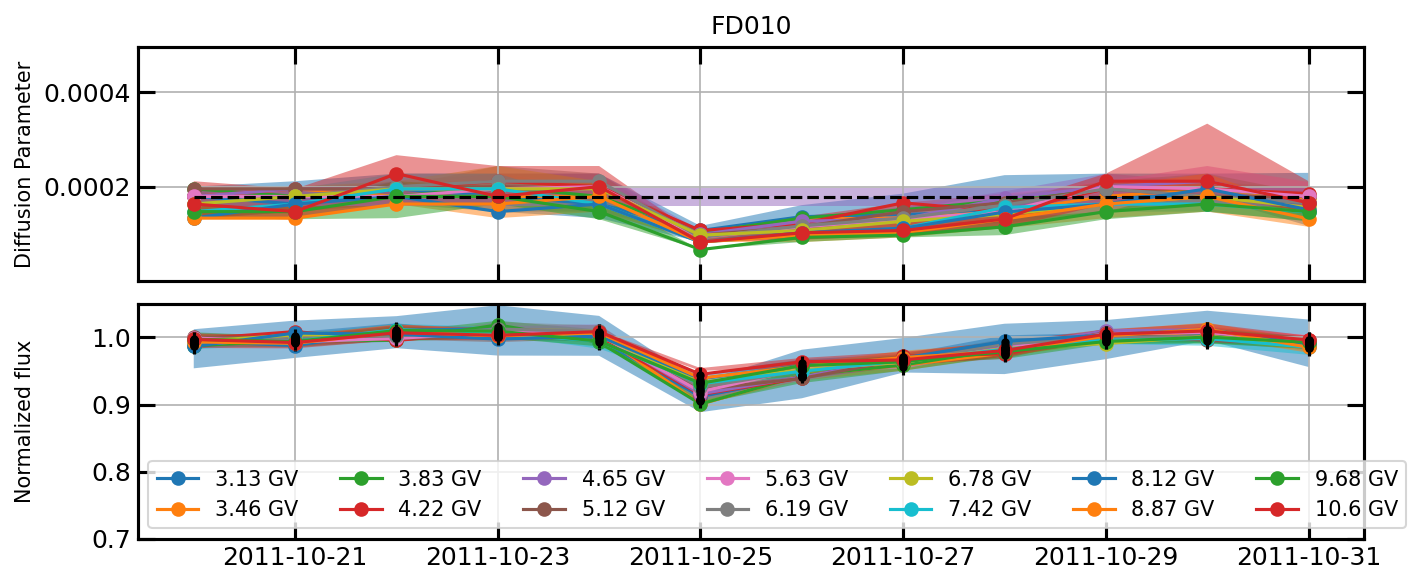

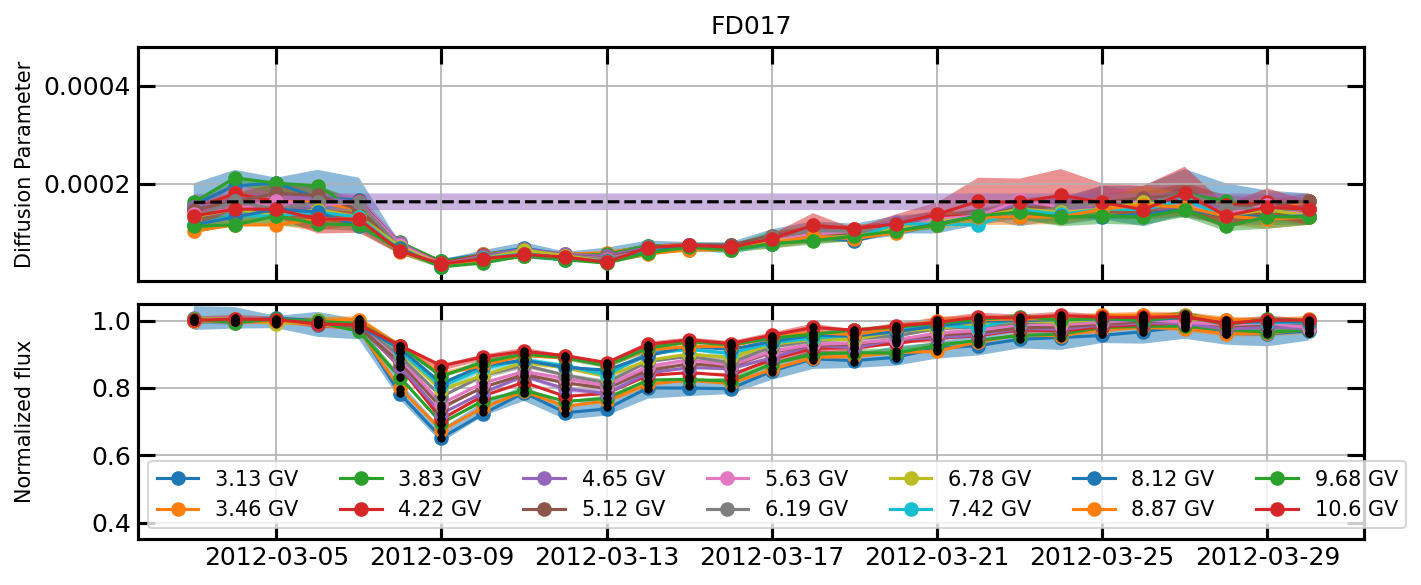

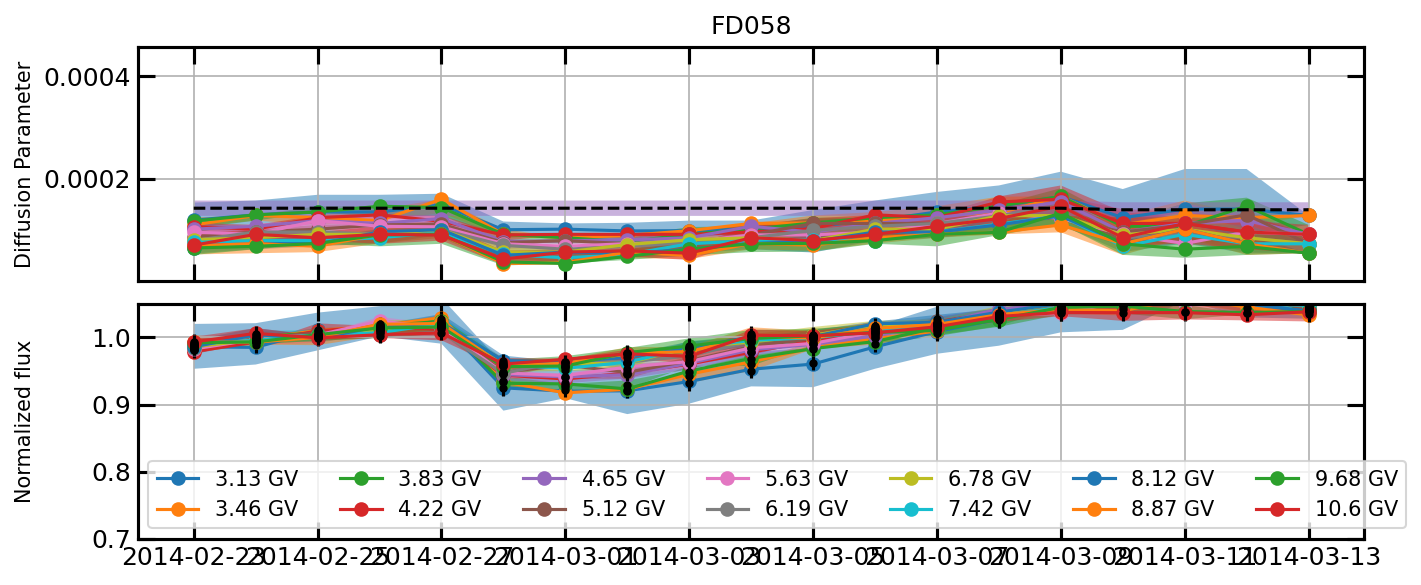

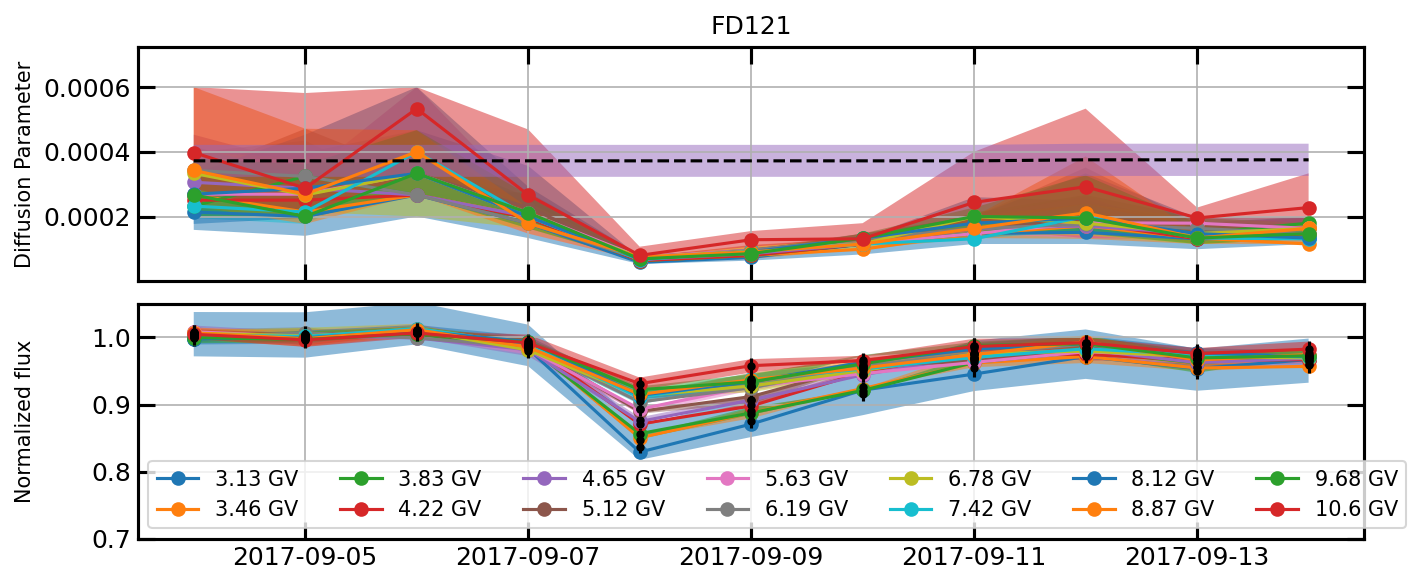

In [5]:
# crea plot - Protoni
Ion='Proton'
for FDid in FDList:
    # File da leggere
    # file_path = f'Result_FD{FDid}.pkl'
    # output_dict = leggi_file_pkl(file_path)
    print(f"==================== {FDid} ==================== ")

    # leggi il file
    output_dict = leggi_files_pkl_from_FDid(FDid)
    crea_grafici_K0Flusso_AllEnergies(output_dict[Ion],FDid=FDid)
    

==================== Result_FD006.pkl ==================== 
---Proton---
==================== Result_FD010.pkl ==================== 
---Proton---
==================== Result_FD017.pkl ==================== 
---Proton---
==================== Result_FD058.pkl ==================== 
---Proton---
==================== Result_FD121.pkl ==================== 
---Proton---


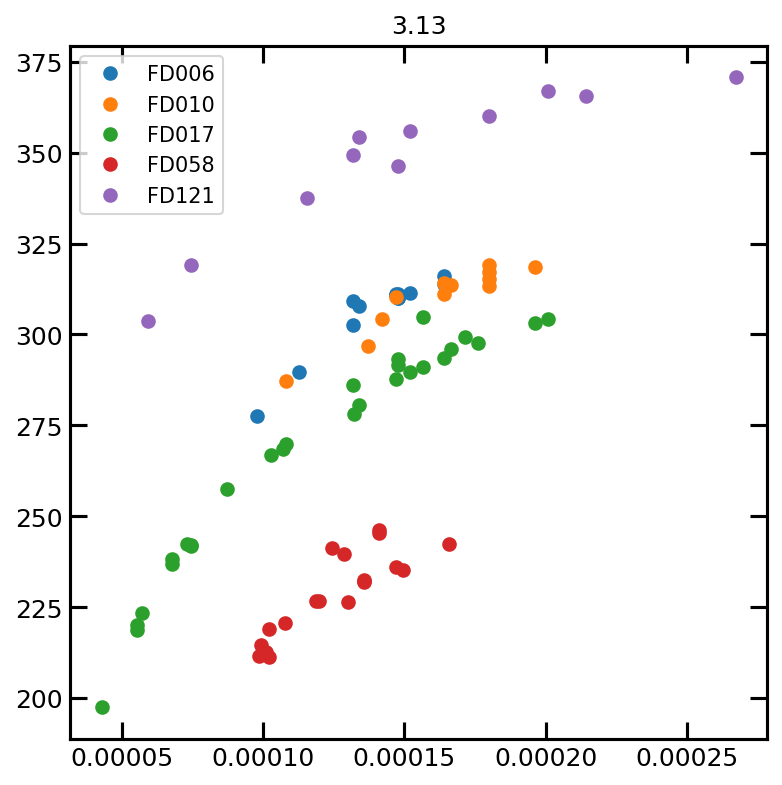

In [6]:
# K0 vs flux
import scipy
Ion='Proton'
fig, ax = plt.subplots(1, 1, figsize=(6, 6), sharex=True)
for FDid in FDList:
    # File da leggere
    file_path = f'Result_FD{FDid}.pkl'
    print(f"==================== {file_path} ==================== ")

    # leggi il file
    data = leggi_files_pkl_from_FDid(FDid)[Ion]
        # Creazione del grafico

    Elist=list(data.keys())
    iE=0


    
  
    ax.set_title(Elist[iE])
    energia = Elist[iE]
    tempo_k0=data[energia]
    
    tempi = list(tempo_k0.keys())
    output_k0 = list(tempo_k0.values())
    valori_k0 = [ f['K0best'] for f in output_k0]
    valori_k0min = [ f['K0Min'] for f in output_k0]
    valori_k0max = [ f['K0Max'] for f in output_k0]
    #print(valori_k0)
    #estrai valor K0 di riferimento

    # estrai valori di flusso
    valori_fluss    = np.array([ f['Fluxbest'] for f in output_k0])
    valori_min      = np.array([ f['FluxMin'] for f in output_k0])
    valori_max      = np.array([ f['FluxMax'] for f in output_k0])
    valori_fExp      = np.array([ f['fExp'] for f in output_k0])
    valori_ErExp_inf = np.array([ f['ErExp_inf'] for f in output_k0])
    valori_ErExp_sup = np.array([ f['ErExp_sup'] for f in output_k0])

    ax.plot( valori_k0,valori_fluss,'o',label=f"FD{FDid}" )
 #   ax.set_xscale('log')
 #   #ax.set_yscale('log')
 #   def func(x, a, b):
 #       return a+b*np.log(x)
 #   popt, pcov = scipy.optimize.curve_fit(func,  valori_k0,valori_fluss)
 #   ax.plot( valori_k0,valori_fluss/func(1e-4, *popt),'o' )
 #   ax.plot( valori_k0, func(valori_k0, *popt)/func(1e-4, *popt), 'r-',label='fit: a=%5.3f, b=%5.3f' % tuple(popt))
 #   print('fit: a=%5.3f, b=%5.3f' % tuple(popt))
plt.legend()
plt.show()

In [7]:
# grafico bontà simulazione
# --- versione 1
# Funzione per creare grafici per tutte le energia
def crea_grafici_K0VsEnergia(data,Emin=-1,Emax=-1,FDid='000'):
    # ottieni lista energia
    Elist=data.keys()
    if Emin==-1: Emin=min(Elist)
    else: Emin = min(Elist, key=lambda x: abs(x - Emin))
    if Emax==-1: Emax=max(Elist)
    else: Emax = min(Elist, key=lambda x: abs(x - Emax))

    Tlist={}
    # Disegno dei grafici su ciascun sottografico
    for energia, tempo_k0 in data.items():
        tempi = list(tempo_k0.keys())
        output_k0 = list(tempo_k0.values())
        for iday,day in enumerate(tempi):
            #
            if day not in Tlist: 
                Tlist[day]={
                    'Energy' : [],
                    'K0best' : [],
                    'K0Min'  : [],
                    'K0Max'  : [],
                    'K0ref'  : output_k0[iday]['K0ref'],
                    'K0Err_ref': output_k0[iday]['K0Err_ref'],
                }
            if (output_k0[iday]['K0best']>0 and 
               output_k0[iday]['K0Min']>0 and 
               output_k0[iday]['K0Max']>0):
                # metti almeno 5% di errore se i valori coincidono
                if output_k0[iday]['K0best']==output_k0[iday]['K0Min']:
                    output_k0[iday]['K0Min']*=0.95
                if output_k0[iday]['K0best']==output_k0[iday]['K0Max']:
                    output_k0[iday]['K0Max']*=1.05
                Tlist[day]['Energy'].append(energia)
                Tlist[day]['K0best'].append(output_k0[iday]['K0best'])
                Tlist[day]['K0Min'].append(output_k0[iday]['K0Min'])
                Tlist[day]['K0Max'].append(output_k0[iday]['K0Max'])
                #print(iday, day,json.dumps(Tlist[day])) #, indent=4
    K0min_v=[]
    K0max_v=[]
    for day in Tlist:
        K0min_v.extend(Tlist[day]['K0Min'])
        K0max_v.extend(Tlist[day]['K0Max'])
    K0minLim = np.min(K0min_v)*0.8
    K0maxLim = np.max(K0max_v)*1.2
    # Creazione del grafico
    num_plots = len(Tlist.keys())
    num_cols = min(num_plots, 4)
    num_rows = (num_plots + num_cols - 1) // num_cols

    Pend_day = []
    Pend_val = []
    Pend_err = []
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(3*num_cols+1, 3*num_rows), sharey=True)
    for iday, ax in enumerate(axes.flatten()):
        if iday < num_plots:
            ax.set_title(list(Tlist.keys())[iday])
            TD=Tlist[list(Tlist.keys())[iday]]
            ax.errorbar( TD['Energy'] , TD['K0best'], yerr=[ np.array(TD['K0best'])-np.array(TD['K0Min']), np.array(TD['K0Max'])-np.array(TD['K0best'])],fmt='.' )
            # ax.fill_between(TD['Energy'] ,
            #                 np.ones(len(TD['Energy']))*(TD['K0ref']-TD['K0Err_ref']),
            #                 np.ones(len(TD['Energy']))*(TD['K0ref']+TD['K0Err_ref']),
            #                 alpha=0.2,color='r' )

            # media pesata dei valori di Kobest
            K0best   =  np.array(TD['K0best'])  # Valori centrali della misura
            K0Min = np.array(TD['K0Min'])   # Valori minimi relativi alla misura
            K0Max = np.array(TD['K0Max'])  # Valori massimi relativi alla misura
            # Calcolo della media pesata di K0best
            # Calcolo dei pesi
            pesi = 1 / ((K0Max - K0Min) / 2)**2
            # Calcolo del valore finale della misura (media pesata)
            #print(pesi)
            K0_media_pesata = np.sum(pesi * K0best) / np.sum(pesi)
            # Calcolo dell'incertezza complessiva del risultato
            incertezza_totale = np.sqrt(1 / np.sum(pesi[pesi<1e12]))
            ax.axhline(K0_media_pesata, color='k')
            ax.fill_between(TD['Energy'] ,
                            K0_media_pesata-incertezza_totale,
                            K0_media_pesata+incertezza_totale,
                            alpha=0.2,color='k' )

            # fit 
            energia = np.array(TD['Energy'])
            valori_centrali = np.array(TD['K0best'])
            K0errMin = valori_centrali-np.array(TD['K0Min'])
            K0errMax = np.array(TD['K0Max'])-valori_centrali
            incertezze_asimmetriche = (np.array(TD['K0Max'])-np.array(TD['K0Min']))/2.
            def funzione_lineare(x, m, q):
                return m * x + q
            # Eseguiamo il fit lineare
            parametri_fit, covarianza = curve_fit(funzione_lineare, energia, valori_centrali, sigma=incertezze_asimmetriche)

            # Estraiamo i parametri del fit
            pendenza, intercetta = parametri_fit

            # Calcoliamo l'errore standard sui parametri del fit
            errore_standard_pendenza = np.sqrt(covarianza[0, 0])
            errore_standard_intercetta = np.sqrt(covarianza[1, 1])

            # Plot dei dati sperimentali
            #plt.errorbar(energia, valori_centrali, yerr=incertezze_asimmetriche, fmt='o', label='Dati sperimentali')

            # Plot del fit lineare
            x_range = np.linspace(min(energia), max(energia), 100)
            ax.plot(x_range, funzione_lineare(x_range, *parametri_fit), label=f'm= {pendenza:.2e}+/-{errore_standard_pendenza:.2e}')


            ax.set_ylim(K0minLim,K0maxLim)
            ax.legend(fontsize=8)

            Pend_day.append(list(Tlist.keys())[iday])
            Pend_val.append(pendenza)
            Pend_err.append(errore_standard_pendenza)
        else:
            fig.delaxes(ax) 
    plt.tight_layout()
    plt.savefig(f"FD{FDid}_fit.png",dpi=300)
    plt.show()

    

    fig, axes = plt.subplots(1, 1, figsize=(10, 4), sharey=True)
    axes.errorbar( Pend_day,Pend_val,yerr=Pend_err,fmt='o' )
    axes.set_ylim([-2e-5,2e-5])
    axes.set_ylabel("slope")
    plt.savefig(f"FD{FDid}_fit_slope.png",dpi=300)
    plt.show()


==================== Result_FD006.pkl ==================== 
---Proton---


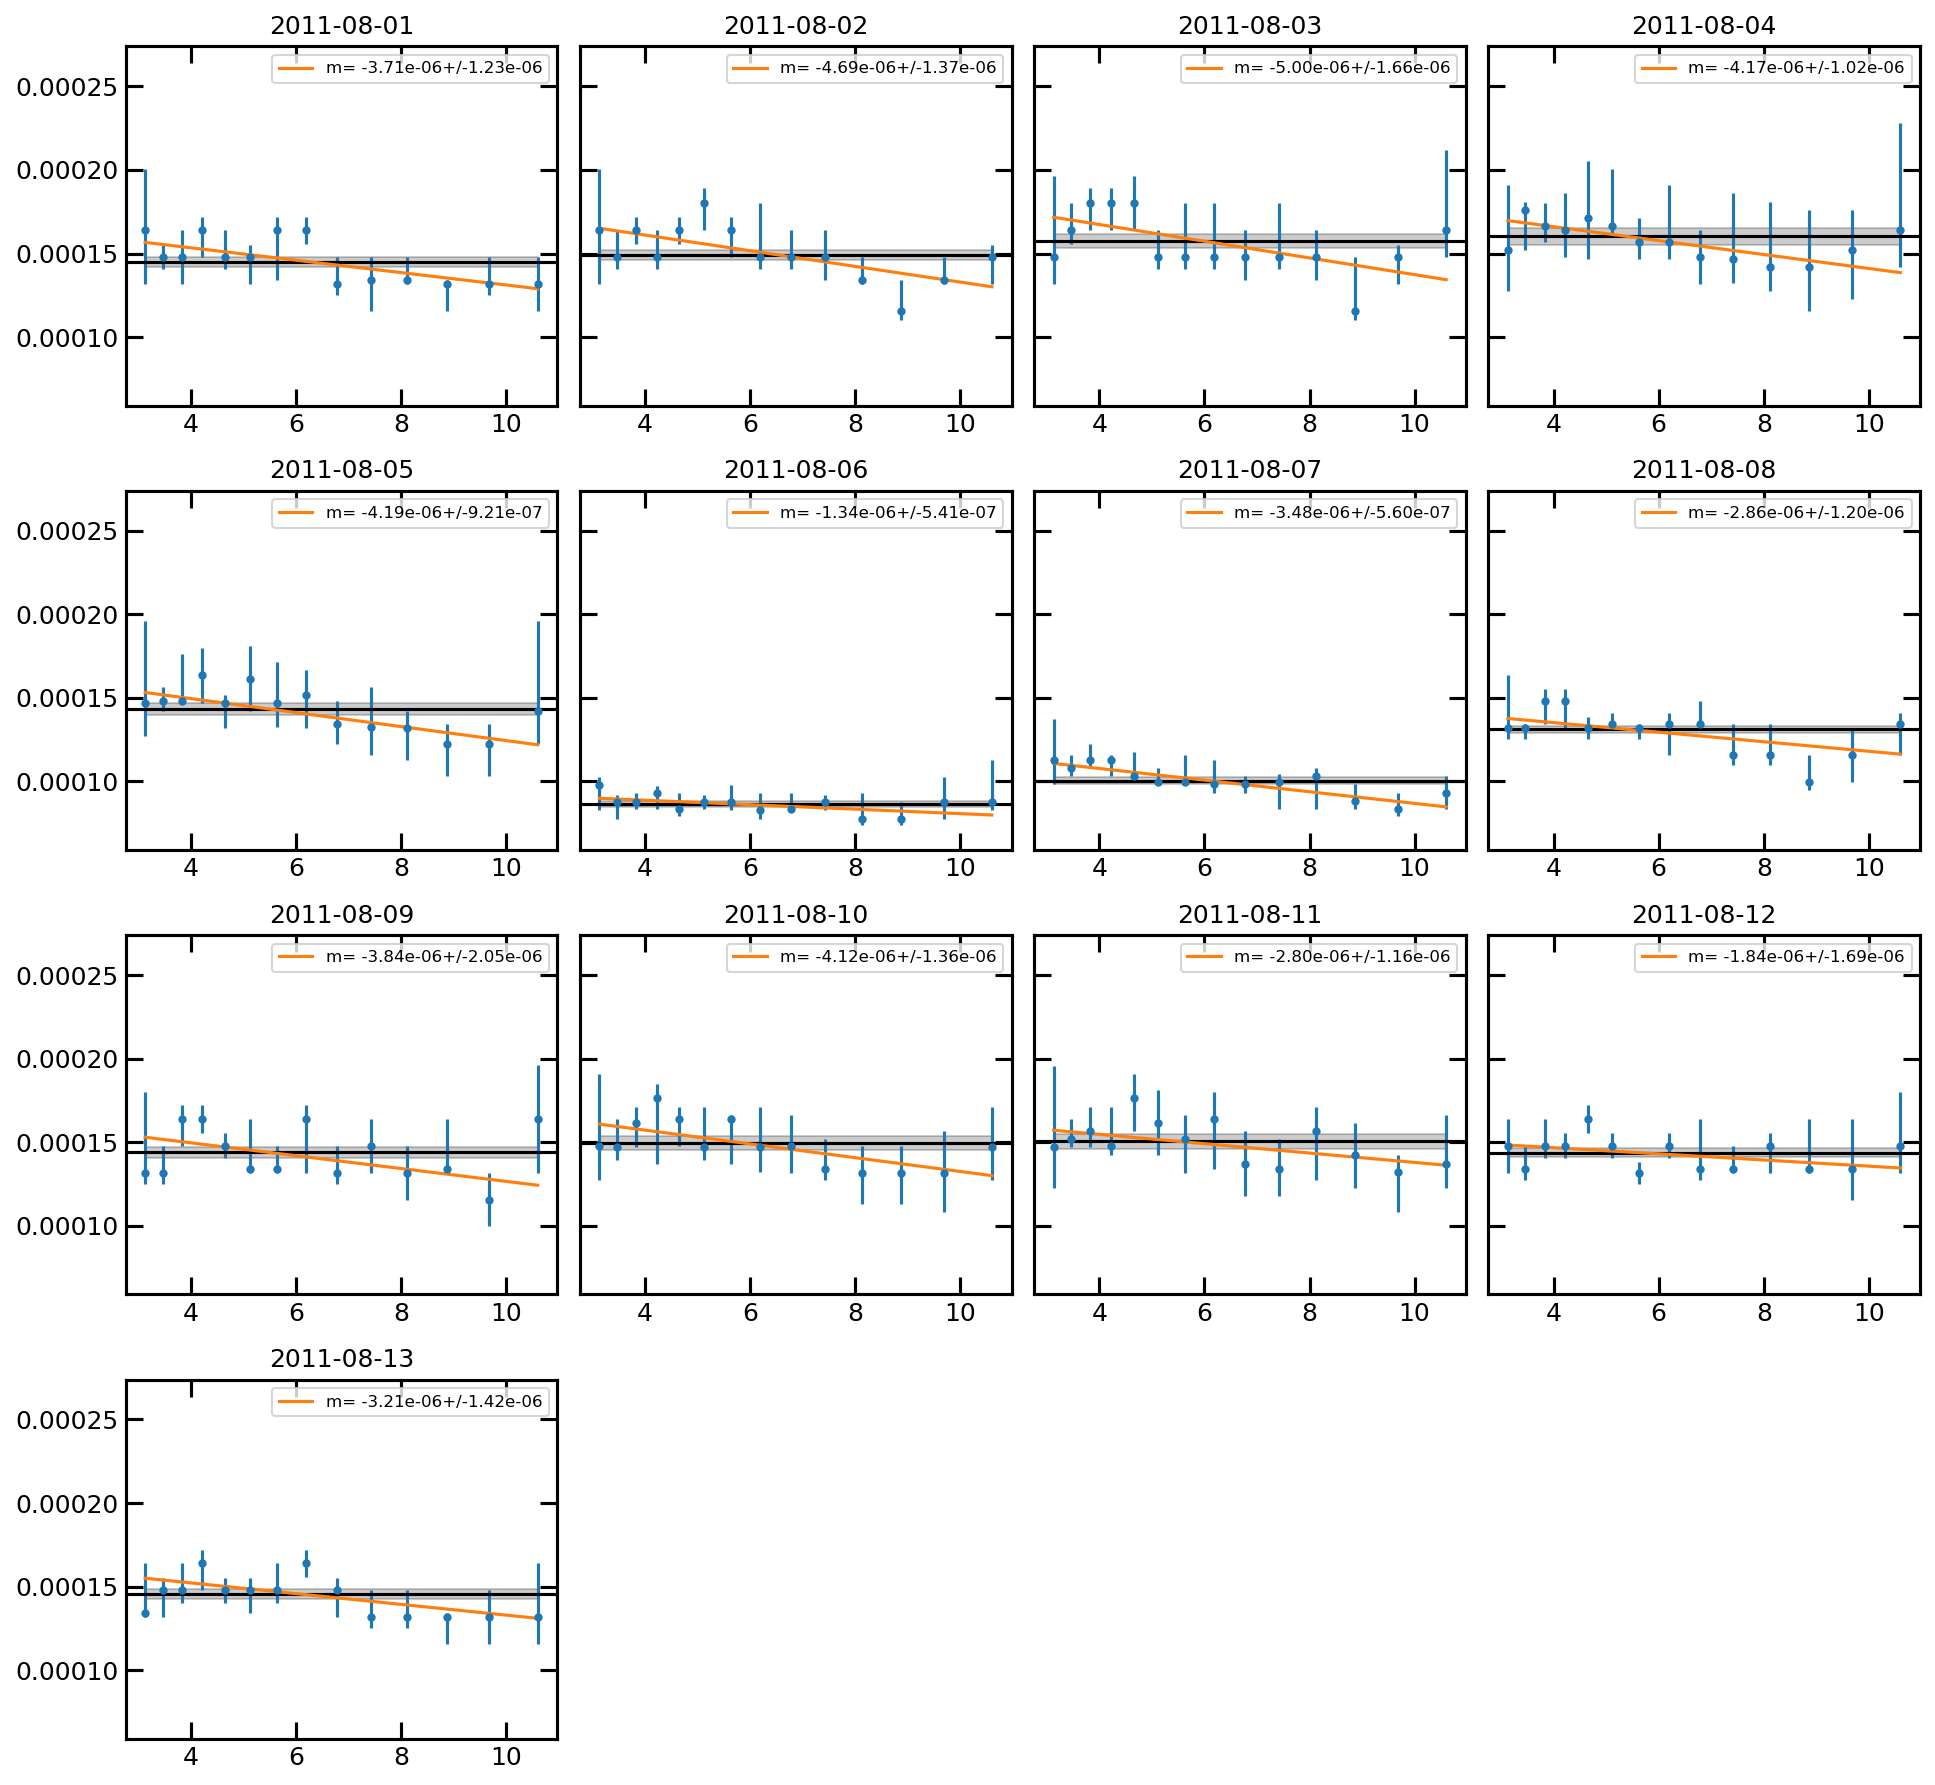

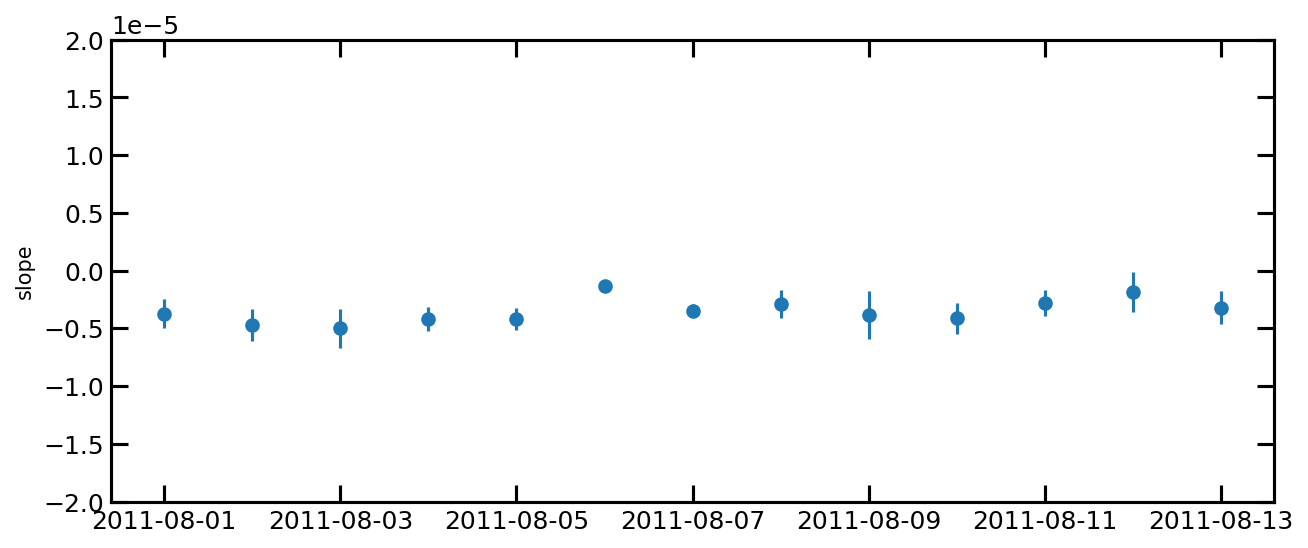

==================== Result_FD010.pkl ==================== 
---Proton---


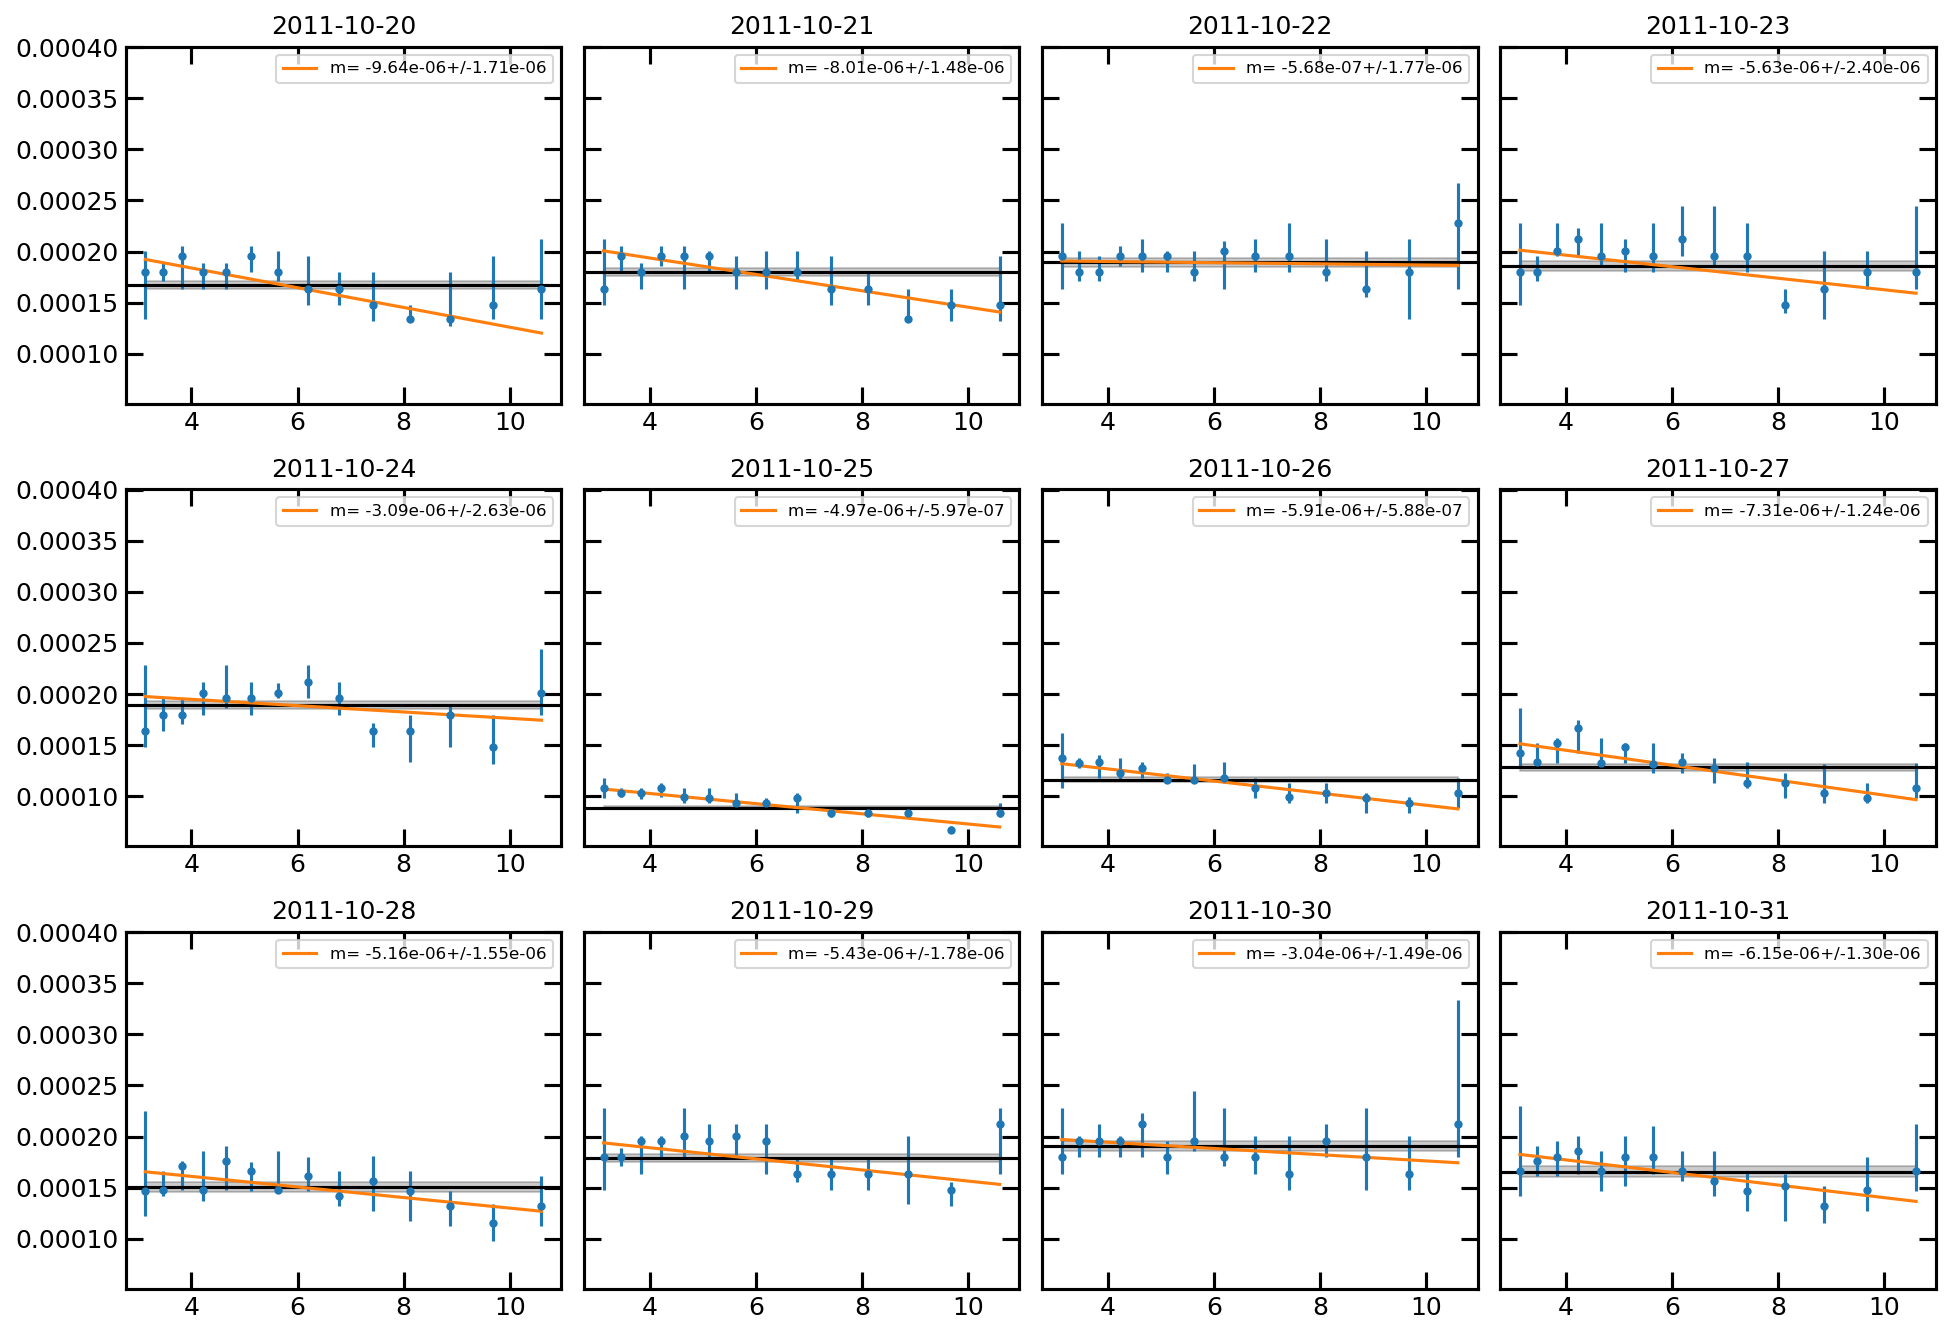

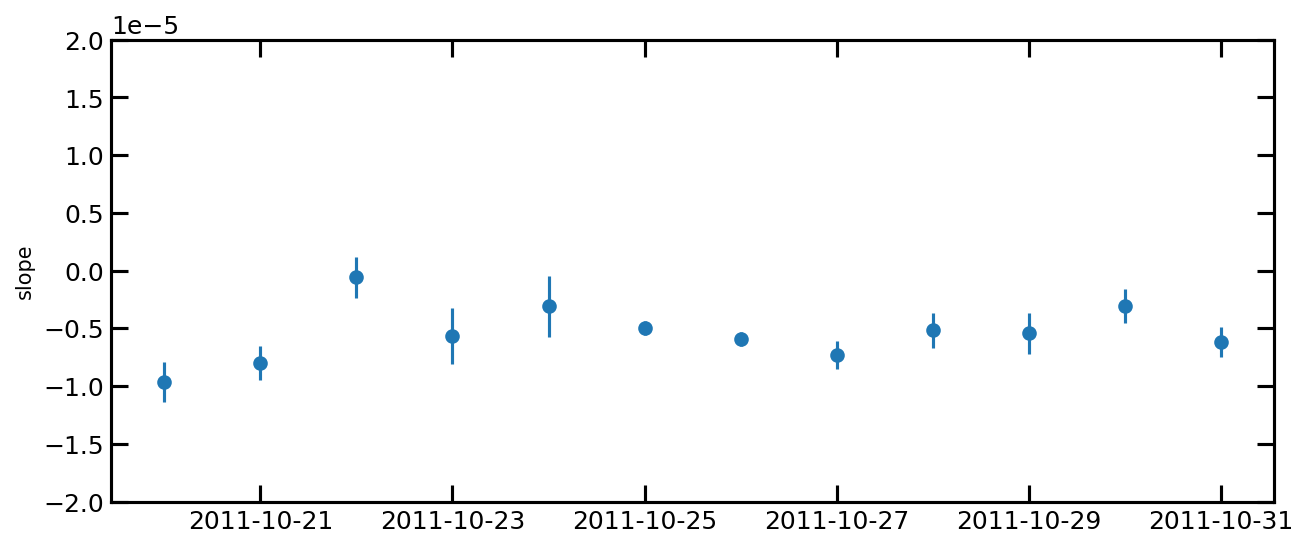

==================== Result_FD017.pkl ==================== 
---Proton---


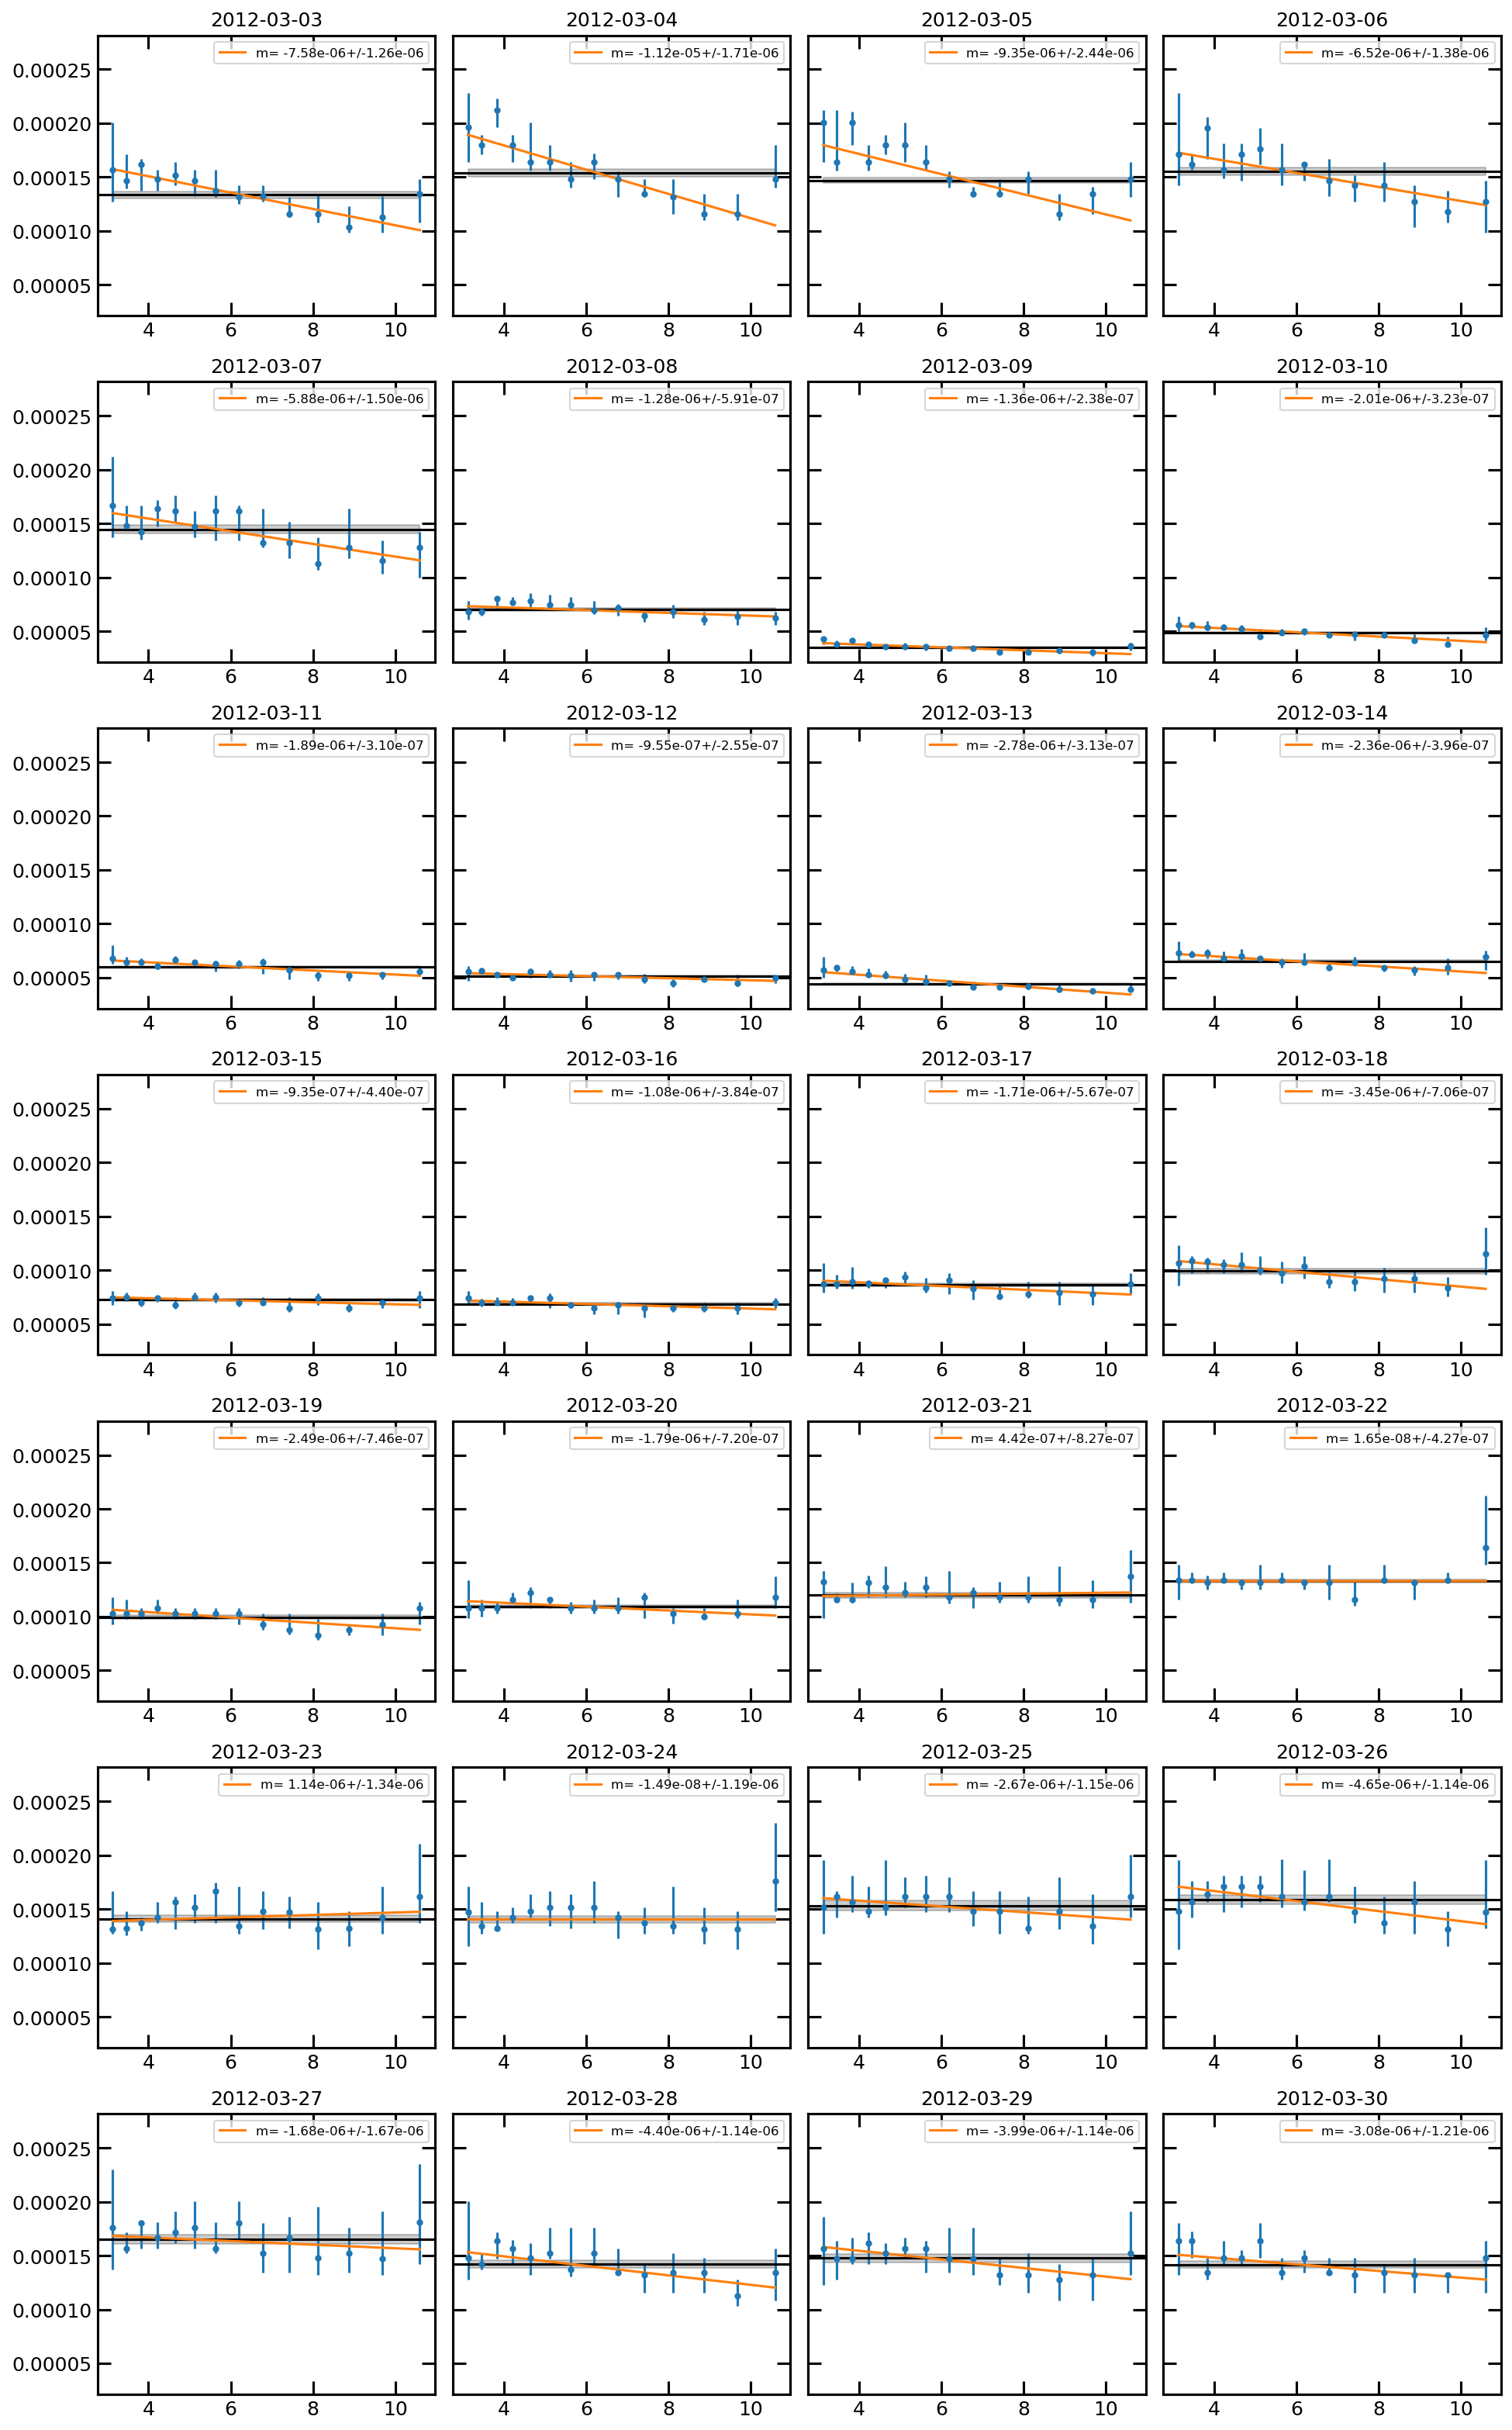

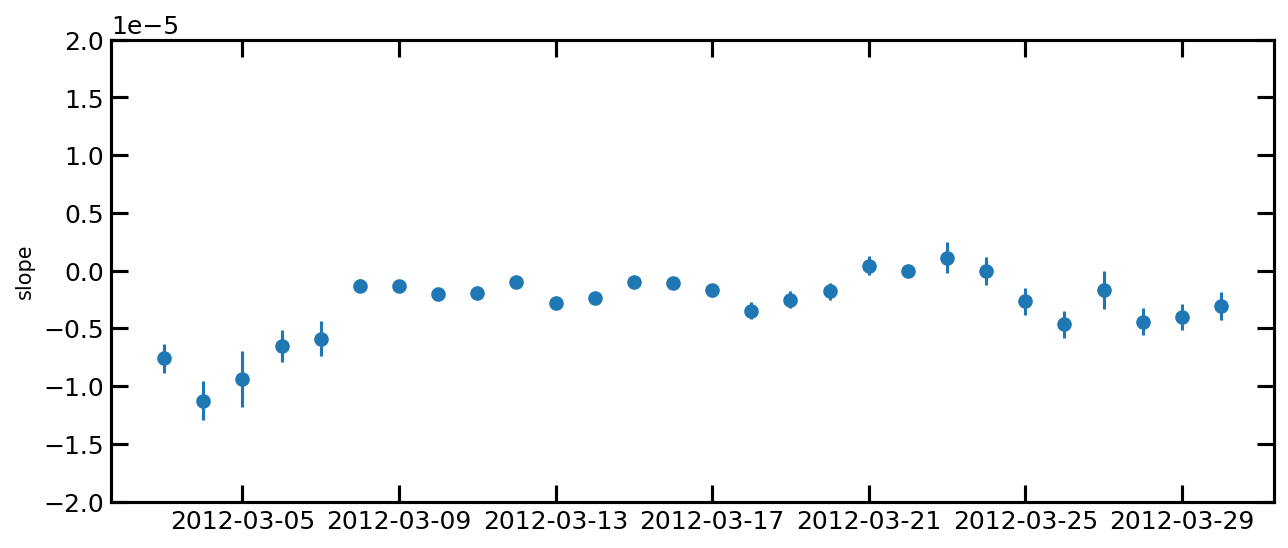

==================== Result_FD058.pkl ==================== 
---Proton---


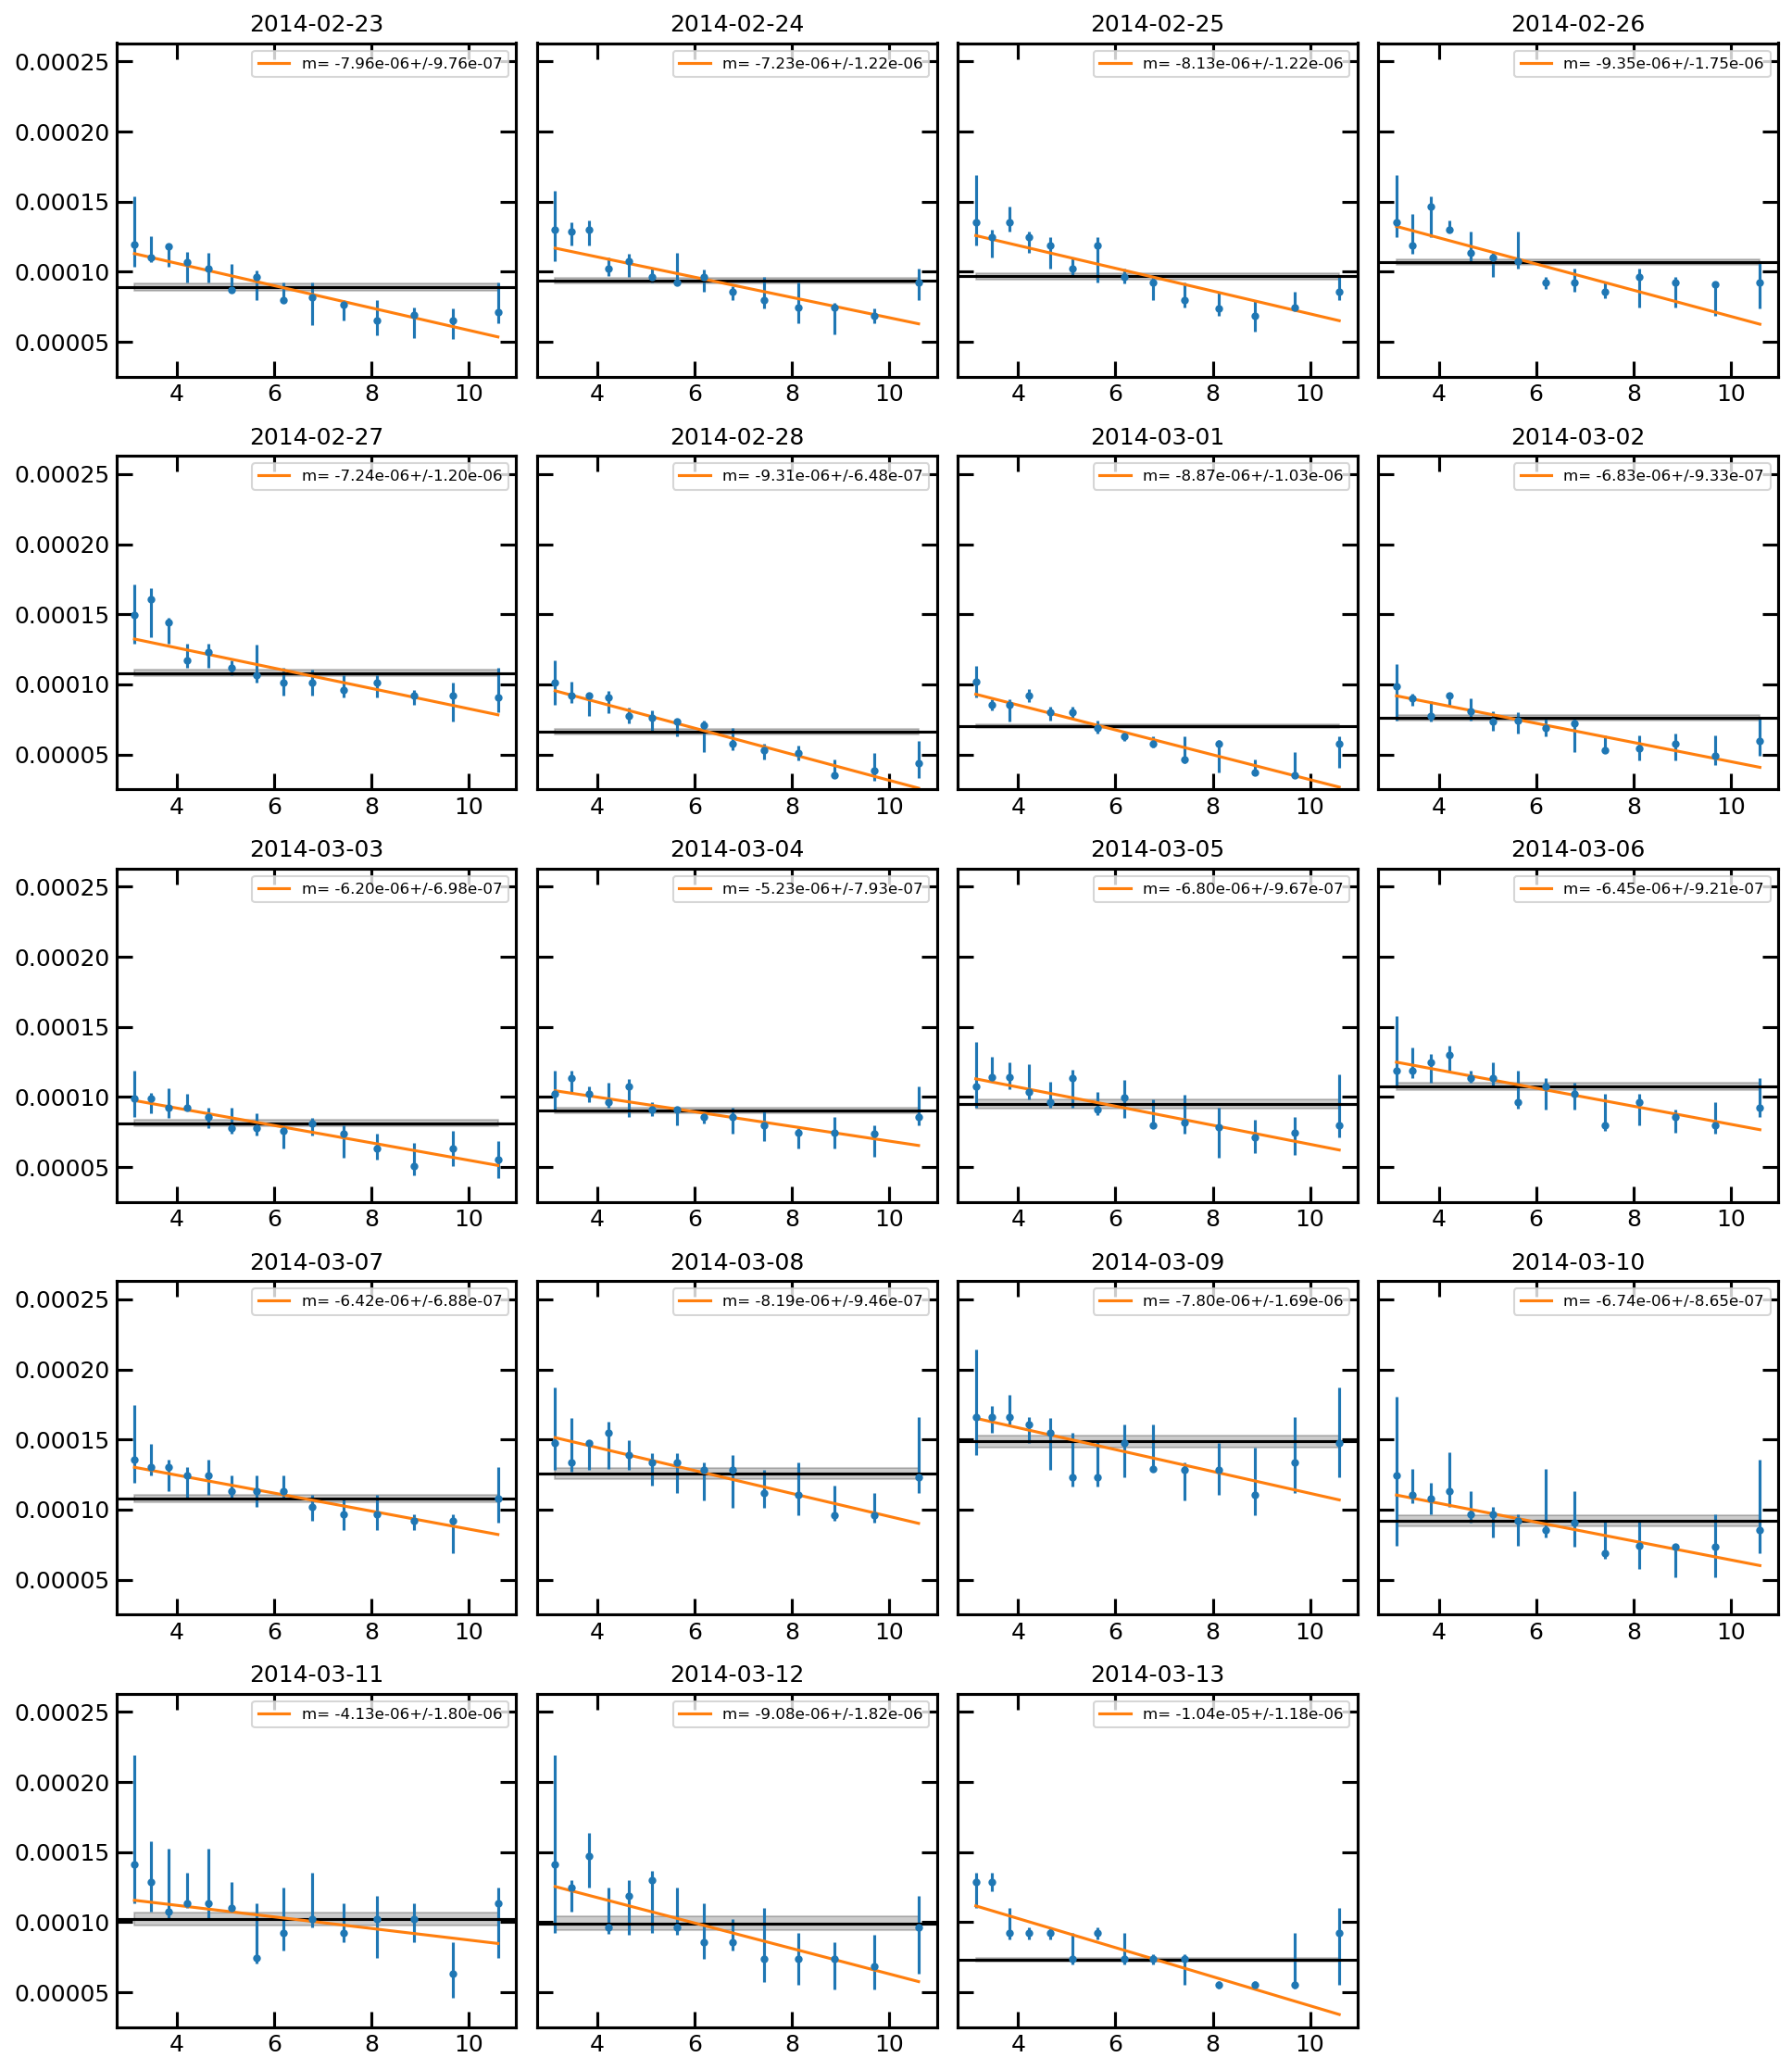

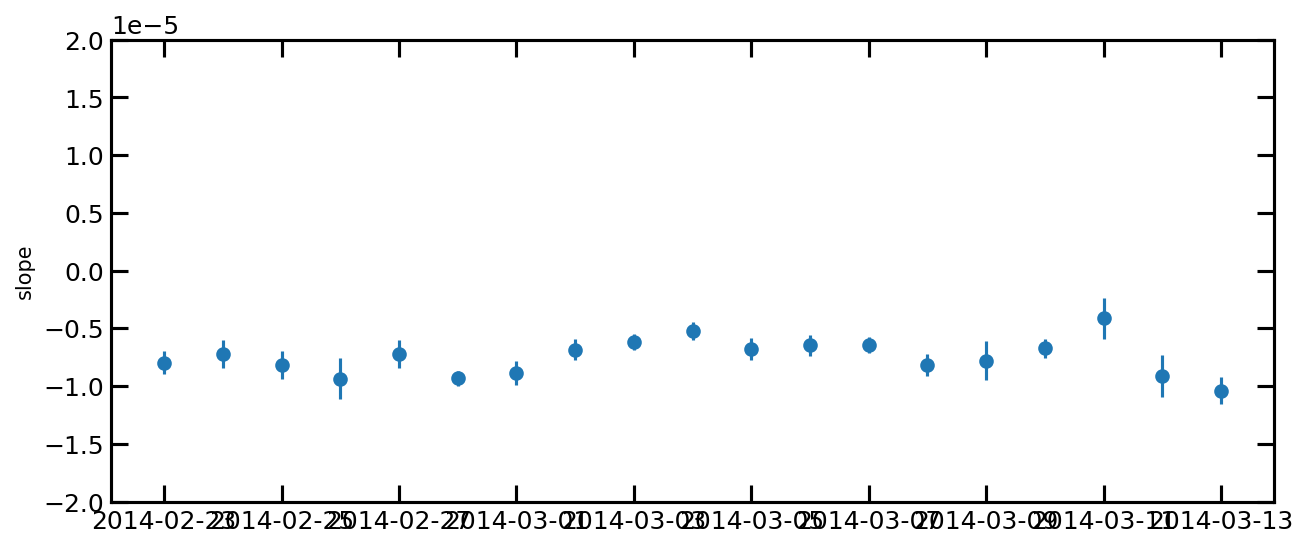

==================== Result_FD121.pkl ==================== 
---Proton---


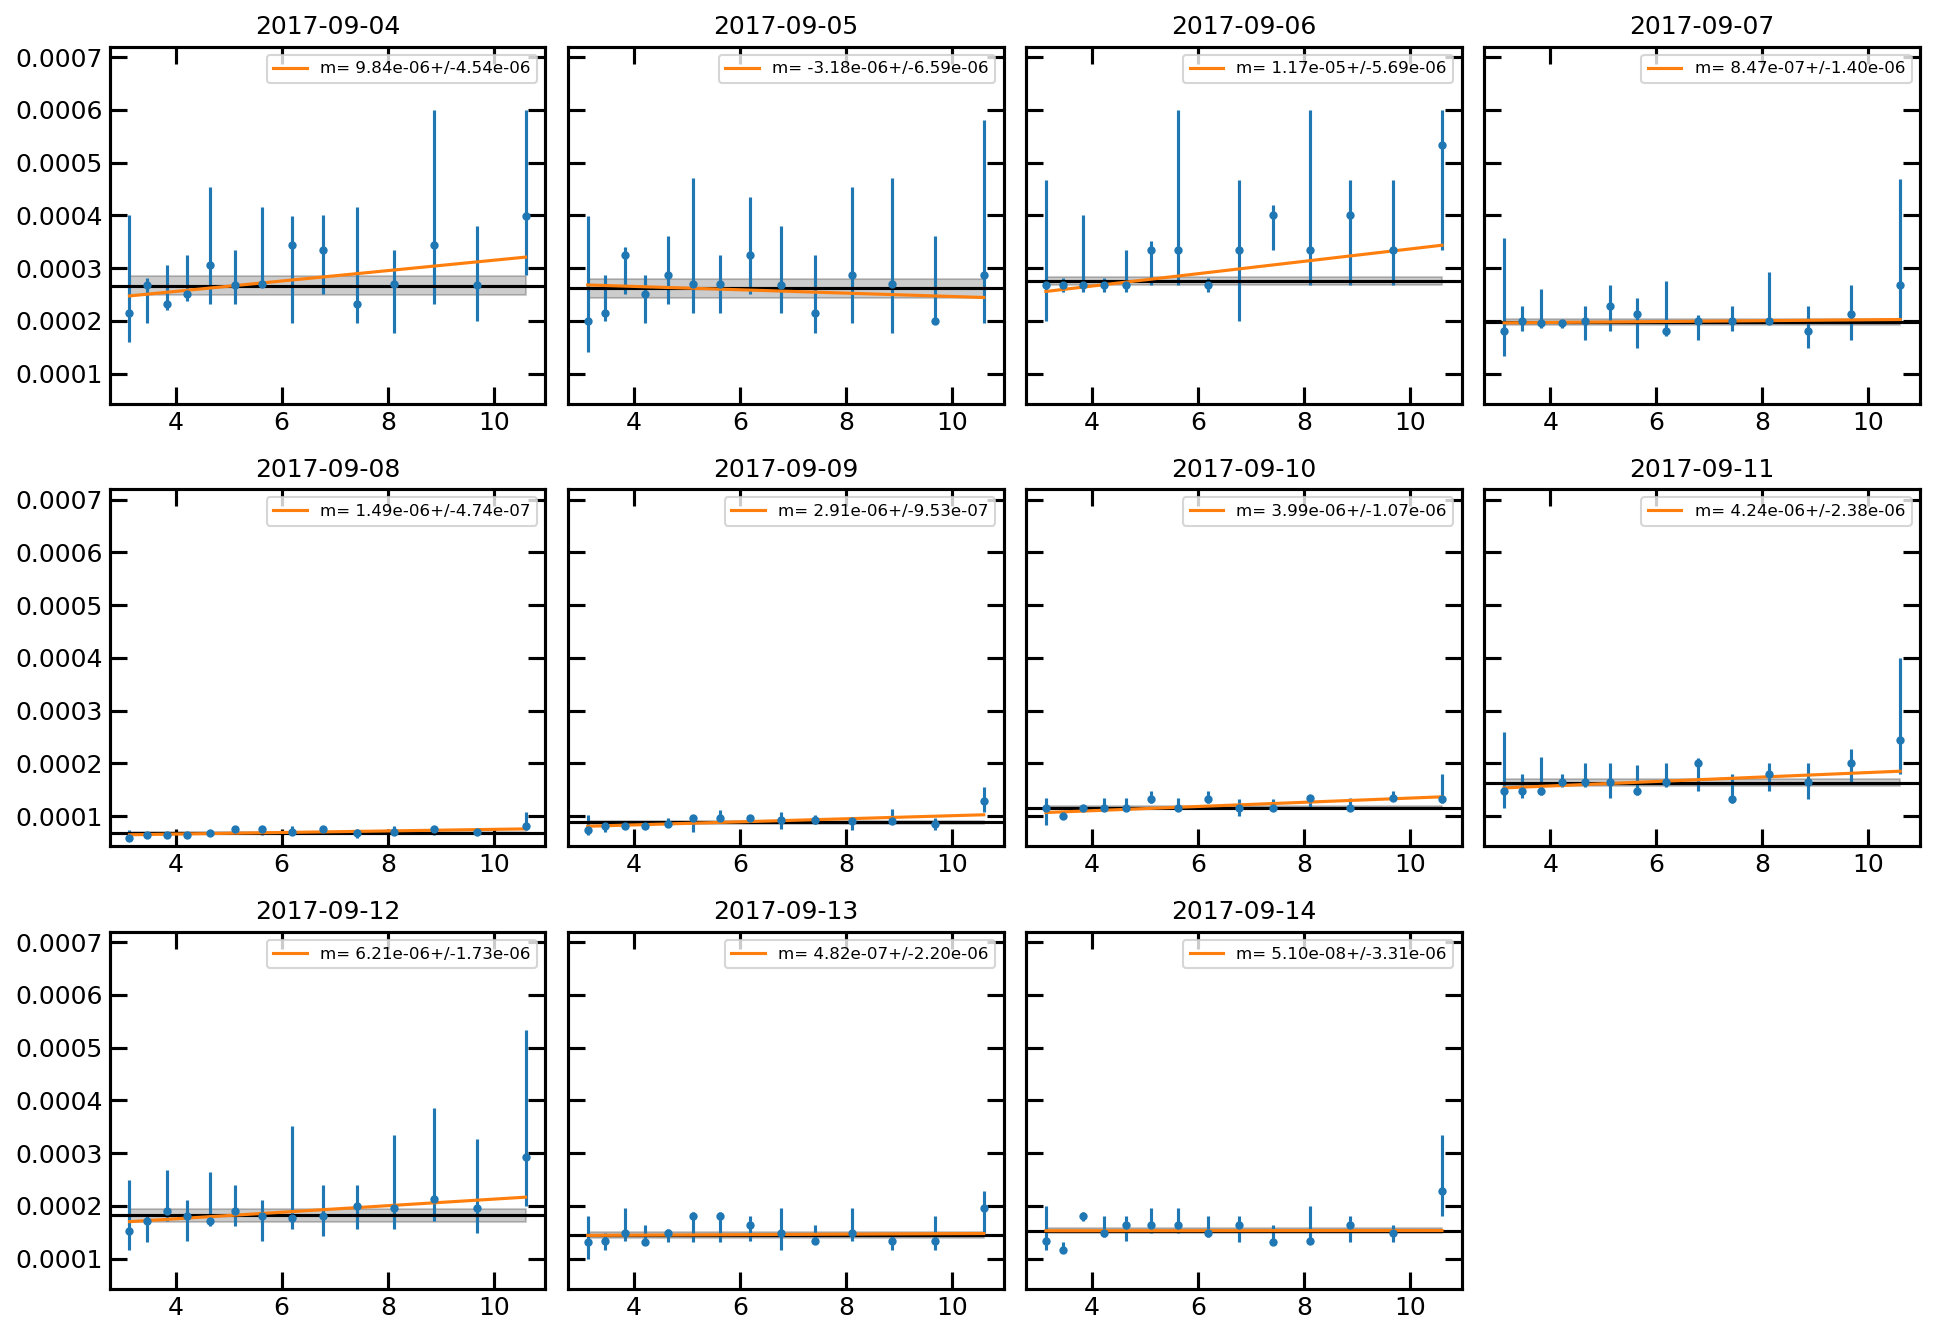

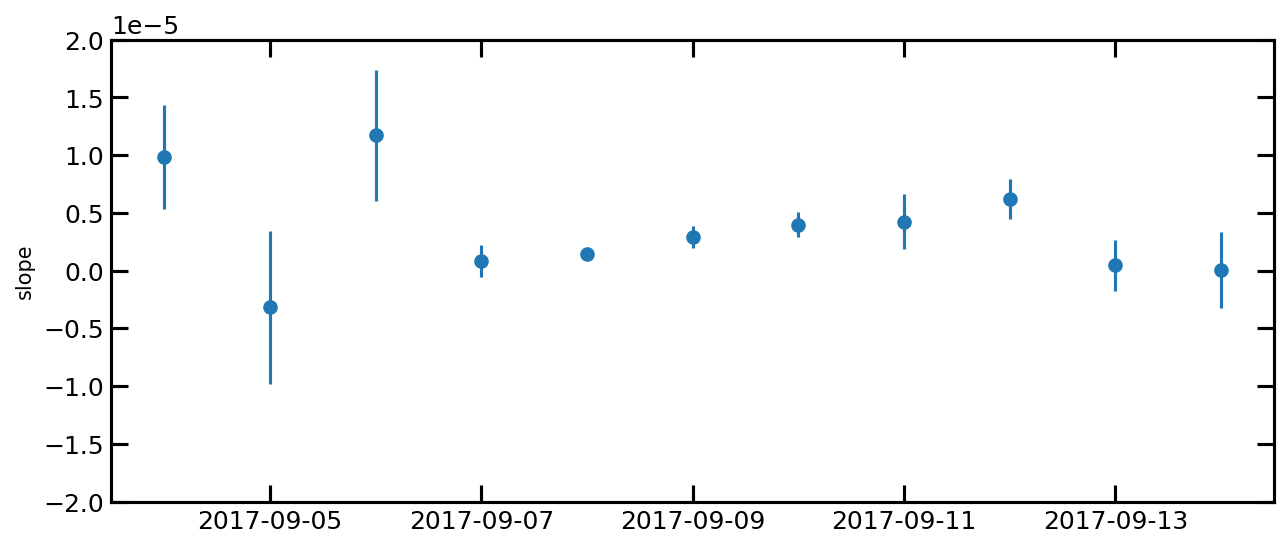

In [8]:
# mostriamo uno stimatore di bontà del fit
Ion='Proton'
for FDid in FDList:
    # File da leggere
    file_path = f'Result_FD{FDid}.pkl'
    print(f"==================== {file_path} ==================== ")

    # leggi il file
    output_dict = leggi_files_pkl_from_FDid(FDid)
    crea_grafici_K0VsEnergia(output_dict[Ion],FDid=FDid)

## Helium

In [9]:
# crea plot - Elio
Ion='Helium'
for FDid in FDList:
    # File da leggere
    file_path = f'Result_FD{FDid}.pkl'
    print(f"==================== {file_path} ==================== ")

    # leggi il file
    output_dict = leggi_file_pkl(file_path)
    crea_grafici_K0Flusso_AllEnergies(output_dict[Ion],FDid=FDid)

==================== Result_FD006.pkl ==================== 


KeyError: 'Helium'

In [ ]:
# 